In [1]:
import os
import subprocess
import re
import numpy as np
import datetime
import itertools
from functools import reduce
import pandas as pd
from utils import *
from matplotlib import pyplot as plt
from IPython import display, get_ipython

# warning this will wipe all data
# cleanup() 

In [2]:
swetest = "/path/swe_unix/src/swetest"
exportPath = '/path/'
marketPath = '/path/'
imgPath = '/path/'

center = (
    'geo'
    # 'helio'
    )

In [3]:
ephes = {
"declination":     [swetest + " -pbody -b1.1.year -ndays -s1 -fd -roundmin -g, -head -hor"],
# "longitude":       [swetest + " -pbody -b1.1.year -ndays -s1 -fl -roundmin -g, -head -hor"],
# "latitude":        [swetest + " -pbody -b1.1.year -ndays -s1 -fb -roundmin -g, -head -hor"],
# "distance":        [swetest + " -pbody -b1.1.year -ndays -s1 -fw -roundmin -g, -head -hor"],
# "speed":           [swetest + " -pbody -b1.1.year -ndays -s1 -fs -roundmin -g, -head -hor"],
# "right_asc":       [swetest + " -pbody -b1.1.year -ndays -s1 -fa -roundmin -g, -head -hor"],
# "meridian_dst":    [swetest + " -pbody -b1.1.year -ndays -s1 -fm -roundmin -g, -head -hor"],
# "zenith_dst":      [swetest + " -pbody -b1.1.year -ndays -s1 -fz -roundmin -g, -head -hor"],
# "azimuth":         [swetest + " -pbody -b1.1.year -ndays -s1 -fi -roundmin -g, -head -hor"],
# "altitude":        [swetest + " -pbody -b1.1.year -ndays -s1 -fh -roundmin -g, -head -hor"],
# "ecliptical":      [swetest + " -pbody -b1.1.year -ndays -s1 -fX -roundmin -g, -head -hor"],
# "equatorial":      [swetest + " -pbody -b1.1.year -ndays -s1 -fx -roundmin -g, -head -hor"],
# "uv_ecliptical":   [swetest + " -pbody -b1.1.year -ndays -s1 -fU -roundmin -g, -head -hor"],
# "uv_equatorial":   [swetest + " -pbody -b1.1.year -ndays -s1 -fu -roundmin -g, -head -hor"],
# "house_pos":       [swetest + " -pbody -b1.1.year -ndays -s1 -fg -roundmin -g, -head -hor"],
# "house_num":       [swetest + " -pbody -b1.1.year -ndays -s1 -fj -roundmin -g, -head -hor"],
# "zodiac":          [swetest + " -pbody -b1.1.year -ndays -s1 -fZ -roundmin -g, -head -hor"],
# "sirius_dec":          [swetest + " -pf -xfSirius -b1.1.year -ndays -s1 -fd -roundmin -g, -head -hor"],
# "sirius_long":          [swetest + " -pf -xfSirius -b1.1.year -ndays -s1 -fl -roundmin -g, -head -hor"],
}

bephes = {
'sun':     [swetest + " -pbody -d0 -b1.1.year -ndays -s1 -fkey -roundmin -g, -head -hor"],
'moon':    [swetest + " -pbody -d1 -b1.1.year -ndays -s1 -fkey -roundmin -g, -head -hor"],
'mercury': [swetest + " -pbody -d2 -b1.1.year -ndays -s1 -fkey -roundmin -g, -head -hor"],
'venus':   [swetest + " -pbody -d3 -b1.1.year -ndays -s1 -fkey -roundmin -g, -head -hor"],
'mars':    [swetest + " -pbody -d4 -b1.1.year -ndays -s1 -fkey -roundmin -g, -head -hor"],
'jupiter': [swetest + " -pbody -d5 -b1.1.year -ndays -s1 -fkey -roundmin -g, -head -hor"],
'saturn':  [swetest + " -pbody -d6 -b1.1.year -ndays -s1 -fkey -roundmin -g, -head -hor"],
'uranus':  [swetest + " -pbody -d7 -b1.1.year -ndays -s1 -fkey -roundmin -g, -head -hor"],
'neptune': [swetest + " -pbody -d8 -b1.1.year -ndays -s1 -fkey -roundmin -g, -head -hor"],
'pluto':   [swetest + " -pbody -d9 -b1.1.year -ndays -s1 -fkey -roundmin -g, -head -hor"], 
    
# "Ear":[swetest + " -pbody -dC -b1.1.year -ndays -s1 -fl -roundmin -g, -head -hor"],

}

keys = [
# 'd',
# 'l',
# 'b',
# 'w',
# 's',
# 'a',
# 'm',
# 'z',
# 'i',
# 'h',
# 'X',
# 'x',
# 'U',
# 'u',
# 'g',
# 'j',
'Z',
]


start = 2020
end = 2023

years = range(start, end)
body = '0123456789'


In [4]:
def createEphemeris(year,body,ephe,key=None):

    days = checkLeap(year)
    
    try:
        command = ephes[ephe][0]
    except KeyError:
        command = bephes[ephe][0]
    
    command = updateCommand(command,body,year,days,center,key)
        
    
    print(command)
    process = subprocess.Popen(command,
    shell=True,
    stdin=None,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE )
    lines = process.communicate()[0].decode('utf-8').splitlines()


    if key:
        if not os.path.exists(exportPath + str(year) + '/csv/' + key):
            os.makedirs(exportPath + str(year) + '/csv/' + key)

        f = open(exportPath + str(year) + '/csv/' + key + '/' + ephe + ".csv", "w+")
        
    else:
        if not os.path.exists(exportPath + str(year) + '/csv/'):
            os.makedirs(exportPath + str(year) + '/csv/')

        f = open(exportPath + str(year) + '/csv/' + ephe + ".csv", "w+")
        
    def writeLine(l, body, ephe, key=None):
        if ephe == 'zodiac':
            l = changeZodiac(l)
        if key == 'Z':
            l = coorZodiac(l)
        else: 
            l = cleanLine(l)
            
        if key:
            f = open(exportPath + str(year) + '/csv/' + key + '/' + ephe + ".csv", "a")
        else:
            f = open(exportPath + str(year) + '/csv/' + ephe + ".csv", "a")

        f.write(l + '\n')
        f.close()
        
    list(map(lambda l: writeLine(l, body, ephe, key), lines))

In [2]:
list(map(lambda year: list(map(lambda ephe: createEphemeris(year, body, ephe), list(ephes))), years))
list(map(lambda year: list(map(lambda bephe: list(map(lambda key: createEphemeris(year, body, bephe, key), keys)), list(bephes))), years))

In [6]:
planets = ["sun", "moon", "mercury", "venus", "mars", "jupiter", "saturn", "uranus", "neptune", "pluto"]

valency = {
'sun':     [1,1,1,1,-1,1,-1,1,-1,-1],
'moon':    [1,1,1,1,-1,1,-1,-1,1,-1],
'mercury': [1,1,1,1,-1,1,-1,1,1,-1],
'venus':   [1,1,1,1,-1,1,-1,1,1,1],
'mars':    [-1,-1,-1,-1,1,-1,-1,-1,-1,-1],
'jupiter': [1,1,1,1,-1,1,-1,-1,1,-1],
'saturn':  [-1,-1,-1,-1,-1,-1,1,-1,-1,-1],
'uranus':  [-1,1,1,1,-1,-1,-1,1,-1,-1],
'neptune': [1,-1,1,1,-1,1,-1,-1,1,-1],
'pluto':   [-1,-1,-1,1,-1,-1,-1,-1,-1,1]
}

aspects = [
    0,
    # 180,
    # 90,
    # 120,
    # 60,

    # 30,
    # 150,
    # 72,
    # 144,
    # 45,
    # 135,
    # 36,
    # 108
]

synodic = {
"long":["jupiter","saturn","uranus","neptune","pluto"],
"middle":["sun","mercury","venus","mars"],
"short":["moon"]
}

In [7]:
def createAspect(year, key, aspect, planet):
    print(year, key, aspect, planet)

    df = pd.read_csv(exportPath + str(year) + '/csv/' + key + '/' + planet  + ".csv", header=None, sep=",")
    
    def _col(col):
        column = df.iloc[:, col]
        
        v = valency[planet][col]
        
        def _calAspect(n):
            if aspect == 60 or aspect == 120:
                if column[n] <= aspect + 15 and column[n] >= aspect - 15:
                    column[n] = np.cos((((column[n] - aspect) / 360) / 10) * 360) * 10
                else:
                    column[n] = 0
  

            if aspect == 90 or aspect == 180:
                if column[n] <= aspect + 15 and column[n] >= aspect - 15:
                    column[n] = np.cos((((column[n] - aspect) / 360) / 10) * 360) * -10
                else:
                    column[n] = 0
             

            if aspect == 0:
                if column[n] <= aspect + 15 and column[n] >= aspect - 15:
                    column[n] = np.cos((((column[n] - aspect) / 360) / 10) * 360) * 10 * v
                else:
                    column[n] = 0
                    
            # else:
            #     if column[n] <= aspect + 15 and column[n] >= aspect - 15:
            #         column[n] = np.cos((((column[n] - aspect) / 360) / 10) * 360) * 10 * v
            #     else:
            #         column[n] = 0                    
            
        list(map(lambda row: _calAspect(row), range(len(column))))
        
    list(map(lambda col: _col(col), df))
    
    if not os.path.exists(exportPath + str(year) + '/csv/' + key + '/' +  str(aspect)):
        os.makedirs(exportPath + str(year) + '/csv/'  + key + '/' + str(aspect))

    path = exportPath + str(year) + '/csv/'  + key + '/' + str(aspect) + '/' + planet + ".csv"
    
    df.to_csv(path, header=None, index=False)



In [3]:
# if you get an error make sure you link ephe to /users in /

list(map(lambda year: list(map(lambda key: list(map(lambda aspect: list(map(lambda planet: createAspect(year, key, aspect, planet), planets)), aspects)), keys)), years))

In [9]:
def createSynodicSum(term, year):
    s_df = []
    
    def calSum(body, aspect, key, term, year):
        print(body, aspect, key, term, year)
        path = exportPath + str(year) + '/csv/' + key + '/' + str(aspect) + '/' + body + ".csv"
        df = pd.read_csv(path, header=None, sep=",")
        s_df.append(df.sum(axis=1))
        
    list(map(lambda body: list(map(lambda aspect:  list(map(lambda key: calSum(body, aspect, key, term, year), keys)), aspects)), synodic[term]))  
        
    s_sum = reduce(lambda x, y: x.add(y, fill_value=0), s_df)
    path = exportPath + str(year) + '/csv/' + "_" + term + "_sum.csv"
    s_sum.to_csv(path, header=None, index=False)


In [4]:
list(map(lambda year: list(map(lambda term: createSynodicSum(term, year), list(synodic))), years))

In [12]:
def getPotency(year):
    
    path = exportPath + str(year) + '/csv/'
    
    D = pd.read_csv(path + 'declination.csv', header=None, sep=",").sum(axis=1)
    L = pd.read_csv(path + '_long_sum.csv', header=None, sep=",")
    M = pd.read_csv(path + '_middle_sum.csv', header=None, sep=",")
    S = pd.read_csv(path + '_short_sum.csv', header=None, sep=",")

    P = (L+D)*5+M
    
    P.iloc[:, 0].to_csv(path + 'siderograph.csv',header=None,index=False)
    

In [13]:
list(map(lambda year: getPotency(year), years))

[None, None, None]

In [14]:
bss = []


years = range(start, end)

def readCSV(year):
    path = exportPath + str(year) + '/csv/'
    p = pd.read_csv(path + 'siderograph.csv',header=None)
    bss.append(p)
    
list(map(lambda year: readCSV(year), years))

p = pd.concat(bss, ignore_index=True, axis=0)
# p['timestamp'] = pd.date_range(start='1/1/' + str(start), periods=len(p), freq='D')
base = datetime.datetime(start,1,1)
p['timestamp'] = list(map(lambda x: base + datetime.timedelta(days=x), range(len(p))))

p = p.set_index('timestamp', drop=True)
p.to_csv(marketPath + 'BS.csv', sep=',')



In [15]:
def log_transform(df):
    # copy the dataframe
    tdf = df.copy()
    # apply log scaling
    for column in tdf.columns:
        tdf[column] = np.log(tdf[column])

    tdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    tdf = tdf.astype(float)
    tdf = tdf.interpolate(method='linear', axis=0).ffill().bfill()
#     tdf = tdf.dropna(axis='columns')
    tdf = tdf.fillna(0)

    return tdf

ticker = 'BTC'
_df = pd.read_csv(marketPath + ticker + '.csv',parse_dates = True,index_col=0)
_df['y'] = _df["close"]
_df['y'] = log_transform(_df['y'].to_frame())

#######################################################################################################

start_date = '2020-01-01'
end_date =   '2030-01-01'

after_start_date = _df.index >= start_date
before_end_date = _df.index <= end_date
between_two_dates = after_start_date & before_end_date
_df = _df.loc[between_two_dates]


#######################################################################################################


# start_date = '2018-01-01'
# end_date = '2023-01-01'

after_start_date = p.index >= start_date
before_end_date = p.index <= end_date
between_two_dates = after_start_date & before_end_date
p = p.loc[between_two_dates]

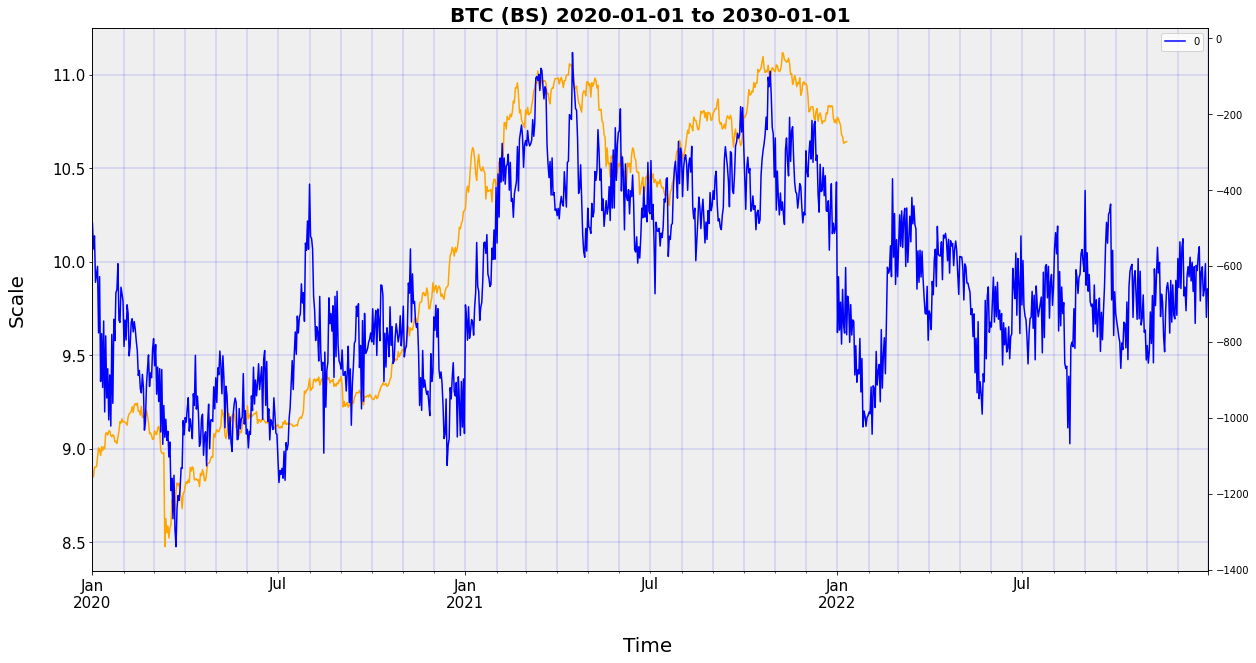

In [16]:
%matplotlib inline

# %config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
# %config InlineBackend.print_figure_kwargs={'edgecolor' : "w"}
# plt.rcParams['axes.facecolor'] = 'w'
# plt.rcParams['axes.edgecolor'] = 'w'
plt.rcParams['savefig.facecolor'] = 'w'

year = start_date + ' to ' + end_date

fig, ax_left = plt.subplots(figsize=(20,10))
ax_right = ax_left.twinx()
_df['y'].plot(xlabel="\nTime ", ylabel="Scale\n", ax=ax_left, color="orange")
p.shift(-0).plot(ax=ax_right, color="blue")

ax_left.xaxis.label.set_size(20)
ax_left.yaxis.label.set_size(20)
ax_left.tick_params(axis='both', which='both', labelsize=15)
ax_left.set_title(ticker + " (BS) " + year, fontsize=20, fontweight="bold")
ax_left.grid(color='b', linestyle='-', linewidth=2, which='both', alpha=0.1)
ax_left.set_facecolor((0.8,0.8,0.8, 0.3))
ax_left.grid(True)
ax_right.grid(False)
ax_right.xaxis.label.set_size(20)
ax_right.yaxis.label.set_size(20)

plt.savefig(imgPath + ticker + " (BS) " + year, bbox_inches='tight')
